In [208]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import csv
import pandas as pd
import numpy as np

import datetime

In [2]:
%load_ext autoreload
%autoreload 1
%aimport hobo

In [5]:
ac206 = hobo.process_data('data/raw/motion-light data/ac206_2018-11-27_fixed.csv')

In [6]:
ac206[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek
2018-10-08 13:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0
2018-10-08 13:57:21-04:00,2,NaN,NaN,NaN,NaN,Logged,NaN,NaN,NaN,0
2018-10-08 13:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [64]:
occupancy = hobo.convert_to_length(ac206, 'Occupancy')

In [9]:
occupancy[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek,delta
2018-10-08 13:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0,NaT
2018-10-08 13:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,00:00:02
2018-10-08 13:59:33-04:00,8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,00:02:11


In [11]:
occ_by_day = hobo.agg_week(occupancy, 'Occupancy')

In [13]:
occ_by_day

dayofweek
0   8 days 07:15:35
1   6 days 22:09:59
2   6 days 05:48:33
3   5 days 02:29:35
4   6 days 21:28:06
5   4 days 05:39:23
6   6 days 00:15:03
Name: delta, dtype: timedelta64[ns]

Text(0.5, 1.0, 'Avg hours of occupancy in AC206 by day of week')

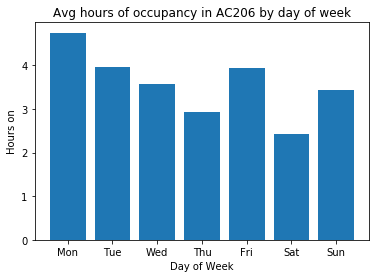

In [15]:
fig = plt.figure()
plt.bar(
    occ_by_day.index,
    occ_by_day / (6*7*np.timedelta64(1, 'h')),
)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Hours on')
plt.title('Avg hours of occupancy in AC206 by day of week')

For a more accurate average, we could normalize by:
- total number of weeks in the dataset
- total number of days in the dataset for each day of the week
- total number of hours in the dataset
- total number of hours in the dataset for each day of the week

### Total number of days

In [41]:
total_time = (ac206[-1:].index - ac206[:1].index)[0]
total_time

Timedelta('50 days 06:47:41')

In [43]:
total_hours = total_time / pd.Timedelta(1, 'h')
total_hours

1206.7947222222222

In [46]:
total_days = total_time / pd.Timedelta(1, 'd')
total_days

50.283113425925926

In [52]:
occ_by_day  # total sums

dayofweek
0   8 days 07:15:35
1   6 days 22:09:59
2   6 days 05:48:33
3   5 days 02:29:35
4   6 days 21:28:06
5   4 days 05:39:23
6   6 days 00:15:03
Name: delta, dtype: timedelta64[ns]

In [39]:
occ_by_day / (6*7*np.timedelta64(1, 'h'))  # previous estimate

dayofweek
0    4.744279
1    3.956343
2    3.566885
3    2.916501
4    3.939722
5    2.420390
6    3.434544
Name: delta, dtype: float64

In [55]:
occ_by_day / ((total_days / 7) * np.timedelta64(1, 'h'))

dayofweek
0    28.465675
1    23.738056
2    21.401310
3    17.499008
4    23.638333
5    14.522341
6    20.607262
Name: delta, dtype: float64

28 hours per day? I think we'll have to calculate total time measured per day of week.

In [58]:
ac206['date'] = ac206.index.normalize()
ac206[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek,date
2018-10-08 13:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00
2018-10-08 13:57:21-04:00,2,NaN,NaN,NaN,NaN,Logged,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00
2018-10-08 13:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00


In [60]:
ac206.groupby('dayofweek').agg(['min','max'])

#       Light      Occupancy                           date  \
            min   max   min  max       min  max                       min   
dayofweek                                                                   
0             1  4104   0.0  1.0       0.0  1.0 2018-10-08 00:00:00-04:00   
1           132  4222   0.0  1.0       0.0  1.0 2018-10-09 00:00:00-04:00   
2           342  4011   0.0  1.0       0.0  1.0 2018-10-10 00:00:00-04:00   
3           586  4015   0.0  1.0       0.0  1.0 2018-10-11 00:00:00-04:00   
4           790  4019   0.0  1.0       0.0  1.0 2018-10-12 00:00:00-04:00   
5          1058  3537   0.0  1.0       0.0  1.0 2018-10-13 00:00:00-04:00   
6          1400  4021   0.0  1.0       0.0  1.0 2018-10-14 00:00:00-04:00   

                                     
                                max  
dayofweek                            
0         2018-11-26 00:00:00-05:00  
1         2018-11-27 00:00:00-05:00  
2         2018-11-21 00:00:00-05:00  
3         2018-11-22 00:00:00-05:00  
4         2018-11-23 00:00:00-05:00  
5         2018-11-10 00:00:00-05:00  
6         2018-11-25 00:00:00-05:00

## Plot ALL the data
(to make sure everything makes sense)

### Every day

In [66]:
occupancy[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek,date,delta
2018-10-08 13:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00,NaT
2018-10-08 13:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00,00:00:02
2018-10-08 13:59:33-04:00,8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00,00:02:11


In [68]:
occupancy.groupby('date')['delta'].agg('sum')

date
2018-10-08 00:00:00-04:00   0 days 06:57:03
2018-10-09 00:00:00-04:00   0 days 23:53:16
2018-10-10 00:00:00-04:00   1 days 00:04:07
2018-10-11 00:00:00-04:00   1 days 01:58:32
2018-10-12 00:00:00-04:00   0 days 22:29:17
2018-10-13 00:00:00-04:00   1 days 02:29:31
2018-10-14 00:00:00-04:00   0 days 23:55:44
2018-10-15 00:00:00-04:00   0 days 19:13:26
2018-10-16 00:00:00-04:00   0 days 20:06:49
2018-10-17 00:00:00-04:00   1 days 00:49:08
2018-10-18 00:00:00-04:00   1 days 02:21:22
2018-10-19 00:00:00-04:00   0 days 22:22:57
2018-10-20 00:00:00-04:00   1 days 00:31:28
2018-10-21 00:00:00-04:00   1 days 00:24:46
2018-10-22 00:00:00-04:00   1 days 02:11:09
2018-10-23 00:00:00-04:00   1 days 00:28:42
2018-10-24 00:00:00-04:00   1 days 00:23:42
2018-10-25 00:00:00-04:00   0 days 21:19:03
2018-10-26 00:00:00-04:00   1 days 04:38:03
2018-10-27 00:00:00-04:00   0 days 17:41:49
2018-10-28 00:00:00-04:00   1 days 00:32:34
2018-10-29 00:00:00-04:00   1 days 03:34:23
2018-10-30 00:00:00-04:00  

### All points, per week

In [108]:
ac206.index >= pd.to_datetime('2018-10-10').tz_localize('US/Eastern')

array([False, False, False, ...,  True,  True,  True])

In [ ]:
fig = plt.figure(figsize=(136,36))
weeks = pd.date_range(start='2018-10-01', end='2018-11-27', freq='w', tz='US/Eastern')
for i, sunday in enumerate(weeks):
    ax = plt.subplot(len(weeks), 1, i + 1, sharex=False)
    week_data = ac206[(ac206.index >= sunday) & (ac206.index < (sunday + pd.to_timedelta(1, 'w')))]
    l = ~week_data['Light'].isnull()
    o = ~week_data['Occupancy'].isnull()
    plt.plot(
        week_data.index[o],
        week_data[o]['Occupancy'],
        drawstyle='steps-post',
        label='occupied'
    )
    plt.plot(
        week_data.index[l],
        week_data[l]['Light'],
        drawstyle='steps-post',  # https://stackoverflow.com/questions/35579480/how-to-plot-square-function-with-matplotlib#35579598
        linestyle=':',
        label='light'
    )
    plt.title('Occupancy sensor')
    plt.yticks([0,1],['no','yes'])
    # plt.ylabel('Value')
    plt.xlabel('Time')
    plt.xticks(pd.date_range(start=sunday, end=(sunday + pd.to_timedelta(1, 'w')), freq='D'))
    plt.legend()
    fig.autofmt_xdate()  # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib#23009503
    fig.patch.set_facecolor('white')  # needed for dark theme https://stackoverflow.com/questions/14088687/how-to-change-plot-background-color
    break


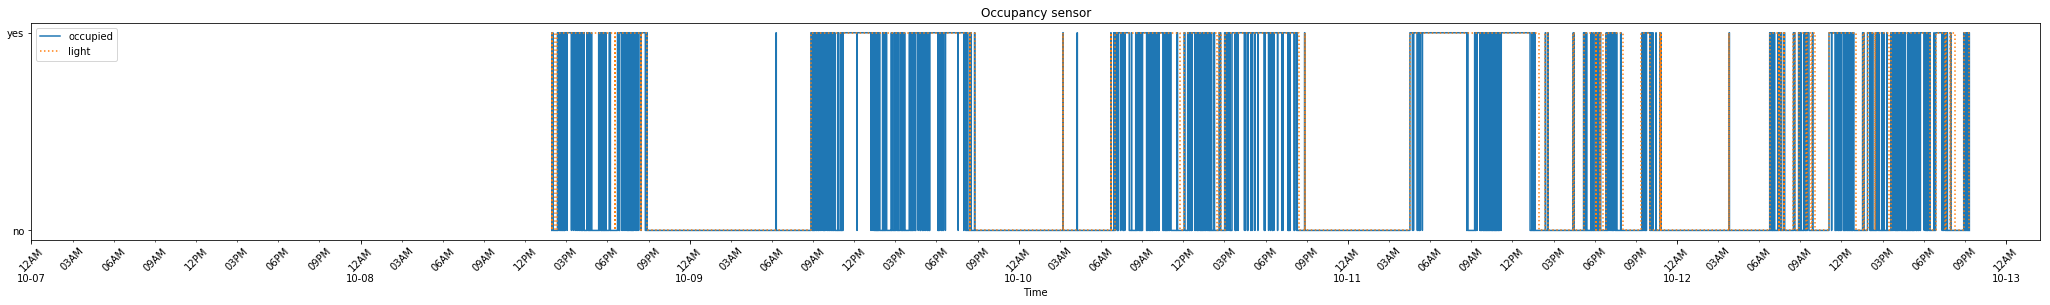

In [214]:
import pytz

def plot_range(d, tstart, tend):
    fig = plt.figure()
    data = d[(d.index >= tstart) & (d.index < tend)]
    l = ~data['Light'].isnull()
    o = ~data['Occupancy'].isnull()
    plt.plot(
        data.index[o],
        data[o]['Occupancy'],
        drawstyle='steps-post',
        label='occupied'
    )
    plt.plot(
        data.index[l],
        data[l]['Light'],
        drawstyle='steps-post',  # https://stackoverflow.com/questions/35579480/how-to-plot-square-function-with-matplotlib#35579598
        linestyle=':',
        label='light'
    )
    ax = plt.gca()
    plt.title('Occupancy sensor')
    plt.yticks([0,1],['no','yes'])
    # plt.ylabel('Value')
    plt.xlabel('Time')
    ax.set_xticks(pd.date_range(start=tstart, end=tend, freq='D'))
#     ax.set_xticks(pd.date_range(start=tstart, end=tend, freq='h'), minor=True)
#     ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d', tz=pytz.timezone('US/Eastern')))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%I%p', tz=pytz.timezone('US/Eastern')))
#     plt.xticks(rotation=45)
    ax.xaxis.set_tick_params(which='major', pad=30)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)  # https://stackoverflow.com/questions/41390487/rotate-minor-ticks-in-matplotlib
    plt.legend()
#     fig.autofmt_xdate()  # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib#23009503
    fig.patch.set_facecolor('white')  # needed for dark theme https://stackoverflow.com/questions/14088687/how-to-change-plot-background-color
    return fig

fig = plot_range(ac206, pd.to_datetime('2018-10-07').tz_localize('US/Eastern'), pd.to_datetime('2018-10-13').tz_localize('US/Eastern'))
fig.set_size_inches(36,4)

In [215]:
fig.savefig('neat.pdf')

In [90]:
ac206.index

DatetimeIndex(['2018-10-08 13:57:20-04:00', '2018-10-08 13:57:21-04:00',
               '2018-10-08 13:57:22-04:00', '2018-10-08 13:57:26-04:00',
               '2018-10-08 13:57:30-04:00', '2018-10-08 13:57:34-04:00',
               '2018-10-08 13:57:38-04:00', '2018-10-08 13:59:33-04:00',
               '2018-10-08 14:00:02-04:00', '2018-10-08 14:01:46-04:00',
               ...
               '2018-11-27 19:17:43-05:00', '2018-11-27 19:43:06-05:00',
               '2018-11-27 19:43:41-05:00', '2018-11-27 19:43:42-05:00',
               '2018-11-27 19:43:58-05:00', '2018-11-27 19:43:59-05:00',
               '2018-11-27 19:44:00-05:00', '2018-11-27 19:44:04-05:00',
               '2018-11-27 19:44:06-05:00', '2018-11-27 19:45:01-05:00'],
              dtype='datetime64[ns, US/Eastern]', length=4222, freq=None)

In [103]:
pd.to_datetime('2018-10-01').tz_localize('US/Eastern')

Timestamp('2018-10-01 00:00:00-0400', tz='US/Eastern')